# Part 2: Parameter Inference

In this notebook we will reconstruct T1 and T2 maps from IR-SE and SE acquisitions. We will use data from a phantom experiment performed at our 1.5T MRI facility. The phantom we used is a [Eurospin Test Object TO5](https://www.leedstestobjects.com/index.php/phantom/t1-t2-gels/), consisting of a set of vials filled with doped gel with different $T_1$ and $T_2$ relaxation times. Run the following script to display a representation of the object and a list of relaxation times for each vial.

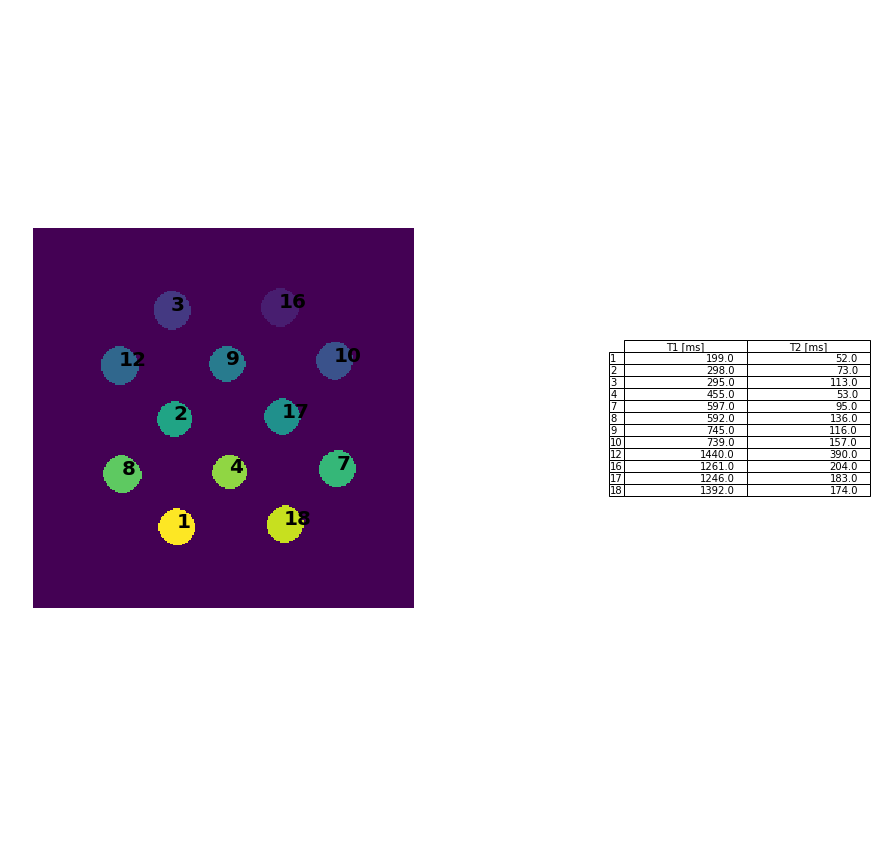

In [43]:
# Setup
import numpy as np
import scipy.io as sio
import scipy.ndimage.measurements as bw
import scipy.ndimage as bin
import scipy.optimize as opt
import matplotlib.pyplot as plt

# load data (In the SE acquisition vials are bigger)
dd = sio.loadmat('data/dataT2.mat')

# legend
lbl = (16, 3, 10, 12, 9, 17, 2, 7, 8, 4, 18, 1) # vial labels according to datasheet
lblTable = np.sort(lbl)
vial_order = np.argsort(lbl) # keep this to sorter measured values

# create phantom lookup-table
label = bw.label(dd["mask"])[0]
centers = np.array(bw.center_of_mass(dd["mask"],label,[1,2,3,4,5,6,7,8,9,10,11,12])).astype(int)

# grount truth values from phantom datasheet
data = [[ 199, 52],
        [ 298, 73],
        [ 295,113],
        [ 455, 53],
        [ 597, 95],
        [ 592,136],
        [ 745,116],
        [ 739,157],
        [1440,390],
        [1261,204],
        [1246,183],
        [1392,174]]

# Build table
columns = ('T1 [ms]', 'T2 [ms]')
rows = ['%d' % x for x in lblTable]
y_offset = np.zeros(len(columns))

# Create text labels for the table
cell_text = []
for row in range(len(data)):
    data[row]
    y_offset = data[row]
    cell_text.append(['%1.1f' % (x) for x in y_offset])

# Plot phantom lookup-table and ground truth values
plt.subplot(1,2,1)
plt.imshow(label)
plt.axis('off')
for t in range(centers.shape[0]):
    plt.text(centers[t,1],centers[t,0],str(lbl[t]),fontsize=20,weight='bold',color='black')

plt.subplot(1,3,3)
plt.axis('off')
plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns,loc='center')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15, 15]

# Ex 01: $T_1$ measurements

In this exercise, we will reconstruct a quantitative $T_1$ map starting from a series of IR-prepared Spin-Echo acquisitions with different $TI$s. First, we will load the data:

Text(0, 0.5, 'Signal Magnitude [a.u.]')

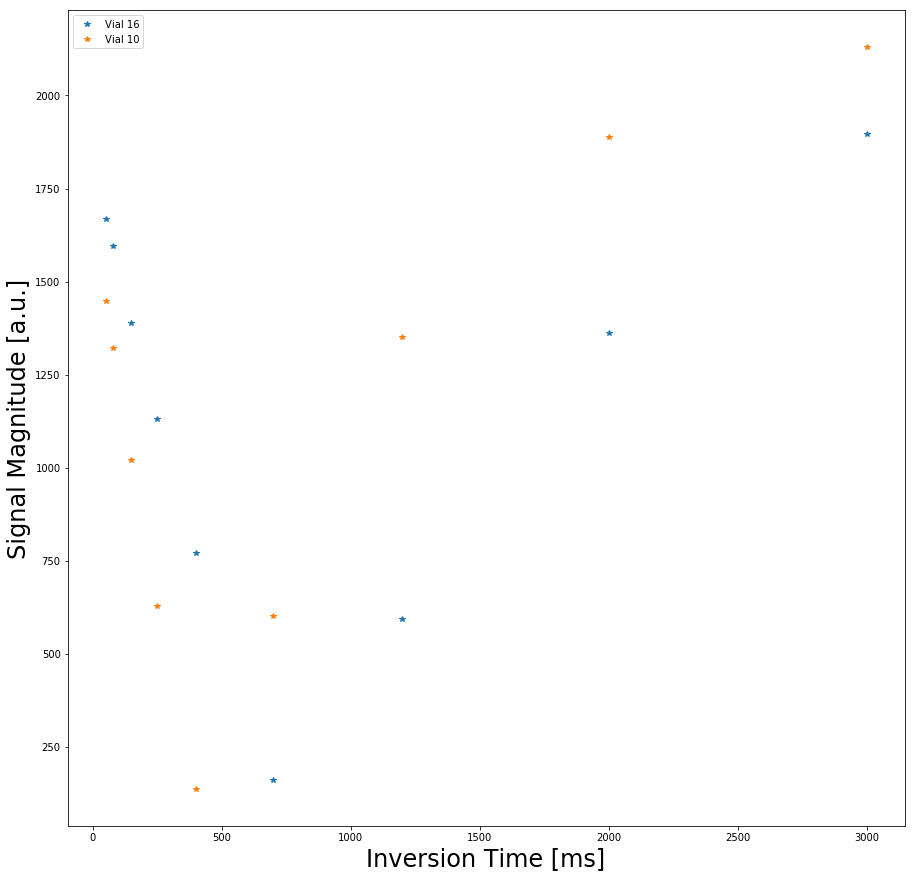

In [44]:
# load data
dd1 = sio.loadmat('data/dataT1.mat')

# get individual vial masks
label = bw.label(dd1["mask"])[0]

# initialize signal matrix
sig1 = np.zeros((len(lbl),dd1["data"].shape[2]),dtype=np.float64)
dsig1 = np.zeros((len(lbl),dd1["data"].shape[2]),dtype=np.float64)

# gather data for each vial
for v in range(len(lbl)):
    for t in range(dd1["data"].shape[2]):
        tmp = dd1["data"][:,:,t]
        vialMask = (label==v+1)
        sig1[v,t] = np.mean(tmp[vialMask].flatten())
        dsig1[v,t] = np.std(tmp[vialMask].flatten())

# plot
TI0 = dd1["TI"]
plt.plot(TI0[0,:],sig1[0,:],'*',label="Vial "+str(lbl[0]))
plt.plot(TI0[0,:],sig1[2,:],'*',label="Vial "+str(lbl[2]))
plt.legend()
plt.xlabel('Inversion Time [ms]',fontsize=24)
plt.ylabel('Signal Magnitude [a.u.]',fontsize=24)

## Pt. 1: IR signal model

By plotting signal intensity as a function of $TI$ for each vial, we can see that we are sampling the longitudinal relaxation curve:

$$
S(TI) \propto (1-2e^{-R_1 \cdot TI})
$$

where $R_1 = 1/T_1$ is the longitudinal relaxation *rate*. Now, define the signal model and perform the fitting procedure (fit routine provided). We will use `scipy.optimize.curve_fit` package. The function handle for the fitting routine should be defined as follow:

``
def func(x,a,b):
    return expr
``

where `x` is the independent variable and `a,b` are the parameters. Call the model `T1model(t,A,R1,C)`. (Hint: try to include an additive constant *C* in the signal model to account for non-zero mean noise, we are using magnitude images!)

In [45]:
# Write the solution below 

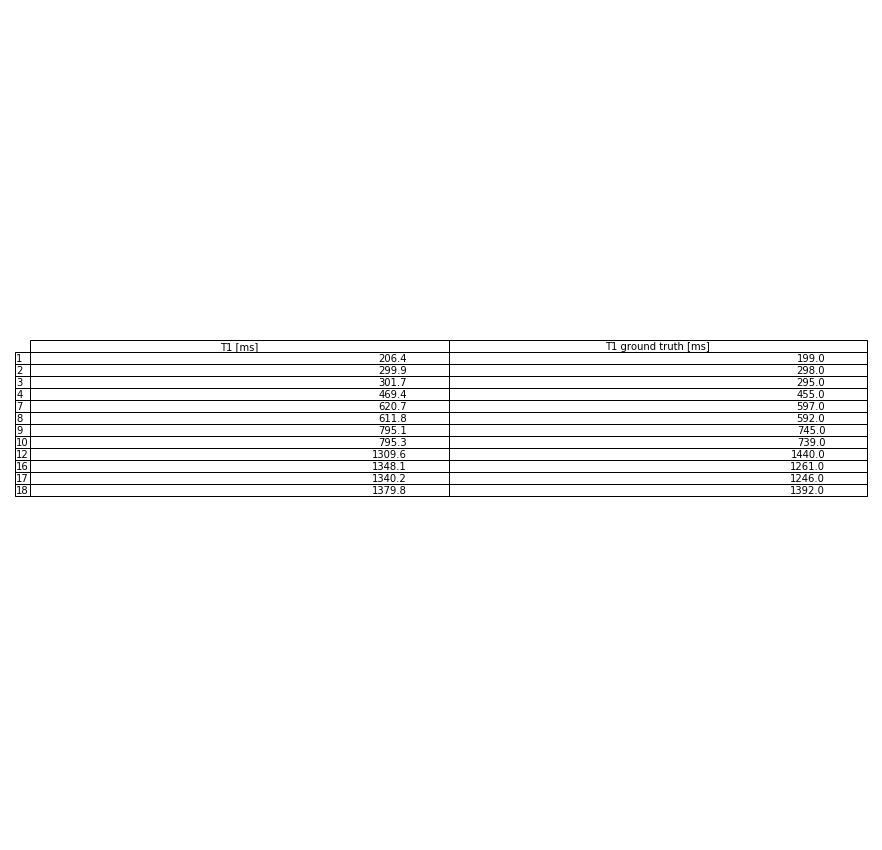

In [46]:
# Prepare data for fitting
order = TI0.argsort()
TI = np.copy(np.sort(TI0))
sig = np.copy(sig1[:,order])
dsig = np.copy(dsig1[:,order])

# Preallocate array of results
T1 = np.zeros(sig.shape[0],dtype=np.float64)
dT1 = np.zeros(sig.shape[0],dtype=np.float64)

# Do fit
for i in range(sig.shape[0]):
    sigTmp = np.copy(sig[i,:])
    dsigTmp = np.copy(dsig[i,:])
    sigTmp[0, 0:sigTmp[0,:].argmin()] = -sigTmp[0, 0:sigTmp[0,:].argmin()] # fix signal sign
    # actual fit
    popt, pcov = opt.curve_fit(T1model, TI[0,:], sigTmp[0,:], sigma=1/dsigTmp[0,:], p0=[sigTmp[0,-1],1/500, sigTmp[0,0]])
    perr = np.sqrt(np.diag(pcov)) # get error
    # store results
    T1[i] = 1/popt[1]
    dT1[i] = perr[1]/(popt[1]**2)

# Reorder solution
T1table = np.copy(T1[vial_order])

# Display results compared to ground truth
columns = ('T1 [ms]', 'T1 ground truth [ms]')
rows = ['%d' % x for x in lblTable]


# Prepare table entries
dataMtx = np.array(data)
dataTable = np.vstack((T1table,dataMtx[:,0])).transpose()

# Set table text
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
# Plot bars and create text labels for the table
cell_text = []
for row in range(len(data)):
    dataTable[row]
    y_offset = dataTable[row]
    cell_text.append(['%1.1f' % (x) for x in y_offset])

plt.subplot(1,1,1)
plt.axis('off')
plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns,loc='center')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15, 15]

# Ex 02: $T_2$ measurements
In this exercise, we will reconstruct a quantitative $T_2$ map starting from a series of Spin-Echo acquisitions with different $TE$s. First, we will load the data:

Text(0, 0.5, 'Signal Magnitude [a.u.]')

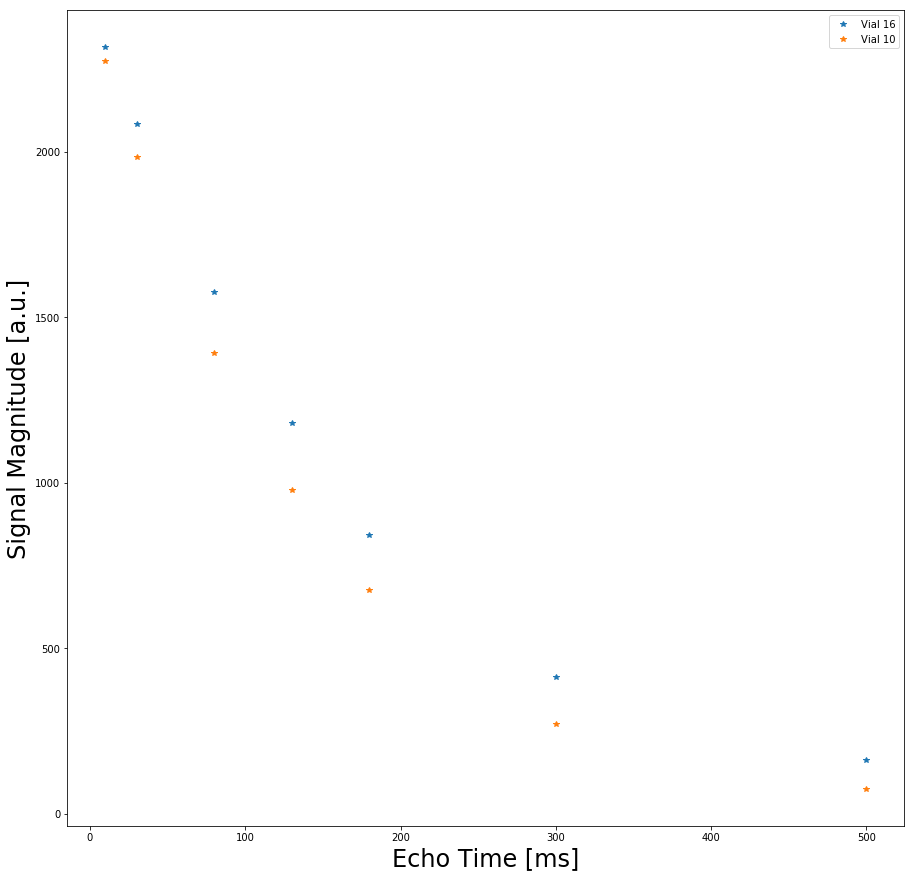

In [47]:
# load data
dd2 = sio.loadmat('data/dataT2.mat')

# get individual vial masks
label = bw.label(dd2["mask"])[0]

# initialize signal matrix
sig2 = np.zeros((len(lbl),dd2["data"].shape[2]),dtype=np.float64)
dsig2 = np.zeros((len(lbl),dd2["data"].shape[2]),dtype=np.float64)

# gather data for each vial
for v in range(len(lbl)):
    for t in range(dd2["data"].shape[2]):
        tmp = dd2["data"][:,:,t]
        vialMask = (label==v+1)
        sig2[v,t] = np.mean(tmp[vialMask].flatten())
        dsig2[v,t] = np.std(tmp[vialMask].flatten())

# plot
TE0 = dd2["TE"]
plt.plot(TE0[0,:],sig2[0,:],'*',label="Vial "+str(lbl[0]))
plt.plot(TE0[0,:],sig2[2,:],'*',label="Vial "+str(lbl[2]))
plt.legend()
plt.xlabel('Echo Time [ms]',fontsize=24)
plt.ylabel('Signal Magnitude [a.u.]',fontsize=24)

## Pt. 1: SE signal model

By plotting signal intensity as a function of $TE$ for each vial, we can see that we are sampling the transverse relaxation curve:

$$
S(TE) \propto (e^{-R2 \cdot TE})
$$

where $R_2 = 1/T_2$ is the transverse relaxation *rate*. Now, define the signal model and perform the fitting procedure (fit routine provided). Again, We will use `scipy.optimize.curve_fit` package. Call the model `T2model(t,A,R2,C)`. (Hint: try to include an additive constant *C* in the signal model to account for non-zero mean noise, we are using magnitude images!)

In [48]:
# Write the solution below

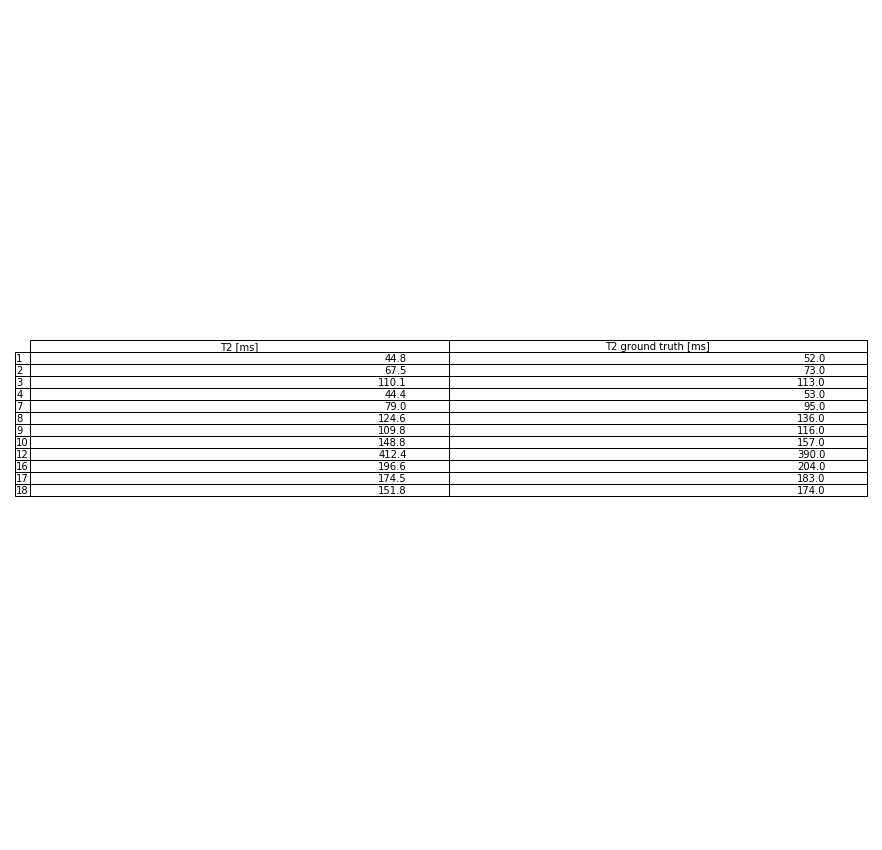

In [49]:
# Prepare data for fitting
order = TE0.argsort()
TE = np.copy(np.sort(TE0))
sig = np.copy(sig2[:,order])

# Preallocate array of results
T2 = np.zeros(sig.shape[0],dtype=np.float64)
dT2 = np.zeros(sig.shape[0],dtype=np.float64)

# Do fit
for i in range(sig.shape[0]):
    sigTmp = np.copy(sig[i,:])
    dsigTmp = np.copy(dsig[i,:])
    # actual fit
    popt, pcov = opt.curve_fit(T2model, TE[0,:], sigTmp[0,:],sigma=1/sigTmp[0,:],p0=[sigTmp[0,0],1/100,sigTmp[0,-1]])
    perr = np.sqrt(np.diag(pcov)) # get error
    # store results
    T2[i] = 1/popt[1]
    dT2[i] = perr[1]/(popt[1]**2)

# Reorder solution
T2table = np.copy(T2[vial_order])

# Display results compared to ground truth
columns = ('T2 [ms]', 'T2 ground truth [ms]')
rows = ['%d' % x for x in lblTable]

# Prepare table entries
dataMtx = np.array(data)
dataTable = np.vstack((T2table,dataMtx[:,1])).transpose()

# Set table text
# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(columns))
# Plot bars and create text labels for the table
cell_text = []
for row in range(len(data)):
    dataTable[row]
    y_offset = dataTable[row]
    cell_text.append(['%1.1f' % (x) for x in y_offset])

plt.subplot(1,1,1)
plt.axis('off')
plt.table(cellText=cell_text, rowLabels=rows, colLabels=columns,loc='center')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [15, 15]